In [23]:
import numpy as np
from numpy.random import normal, uniform
from scipy.stats import multivariate_normal as mv_norm
import matplotlib.pyplot as plt

In [15]:
def real_function(a_0, a_1, noise_sigma, x):
   #Evaluates the real function
    N = len(x)
    if noise_sigma==0:
        # Recovers the true function
        return a_0 + a_1*x
    else:
        return a_0 + a_1*x + normal(0, noise_sigma, N)

In [24]:
class LinearBayes(object):
    """
    A class that holds parameter prior/posterior and handles the hyper-parameter updates with new data.
    Args:
        a_m0 (np.array): prior mean vector of size 1xM
        m_S0 (np.ndarray): prior covariance matrix of size MxM 
    """
    def __init__(self, a_m0, m_S0, beta):
        self.prior = mv_norm(mean=a_m0, cov=m_S0)
        self.v_m0 = a_m0.reshape(a_m0.shape + (1,)) #reshape to column vector
        self.m_S0 = m_S0
        self.beta = beta
        
        self.v_mN = self.v_m0
        self.m_SN = self.m_S0
        self.posterior = self.prior
           
    def get_phi(self, a_x):
        """
        Returns the design matrix of size (NxM) for a feature vector v_x.
        Args:
            a_x (np.array): input features of size 1xN
        """
        m_phi = np.ones((len(a_x), 2))
        m_phi[:, 1] = a_x
        return m_phi
        
    def set_posterior(self, a_x, a_t):
        """
        Updates mN and SN given vectors of x-values and t-values
        """
        v_t = a_t.reshape(a_t.shape + (1,))

        m_phi = self.get_phi(a_x)
        
        self.m_SN = np.linalg.inv(np.linalg.inv(self.m_S0) + self.beta*m_phi.T.dot(m_phi))
        self.v_mN = self.m_SN.dot(np.linalg.inv(self.m_S0).dot(self.v_m0) + \
                                      self.beta*m_phi.T.dot(v_t))
        
        self.posterior = mv_norm(mean=self.v_mN.flatten(), cov=self.m_SN)
    
    def make_contour(self, a_x, a_y, real_parms=[], N=0):
        pos = np.empty(a_x.shape + (2,))
        pos[:, :, 0] = a_x
        pos[:, :, 1] = a_y

        plt.contourf(a_x, a_y, self.posterior.pdf(pos), 20)
        plt.xlabel('$w_0$', fontsize=16)
        plt.ylabel('$w_1$', fontsize=16)
        
        if real_parms:
            plt.scatter(real_parms[0], real_parms[1], marker='+', c='black', s=60)
            
        _ = plt.title('Distribution for Weight Parameters using %d datapoint(s)' % N, fontsize=10)
    
    def make_scatter(self, a_x, a_t, real_parms, samples=None):
        #function to plot noisey data, the true function, and a set of lines specified by the nested array 
        plt.scatter(a_x, a_t, alpha=0.5)
        plt.xlabel('x')
        plt.ylabel('t')

        plt.plot([-1, 1], real_function(real_parms[0], real_parms[1], 0, np.array([-1., 1.])), 'r')

        _ = plt.title('Real Data from Noisey Linear Function')
        
        if samples:
            weights = self.posterior.rvs(samples)
            for weight in weights: 
                plt.plot([-1, 1], real_function(weight[0], weight[1], 0, np.array([-1., 1.])), 'black')
                _ = plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')
                

In [17]:
# Real function parameters
a_0 = -0.3
a_1 = 0.5
noise_sigma = 0.2 #since noise_variance = 0.04
beta = 1/noise_sigma**2
# Generate input features from uniform distribution
np.random.seed(20) 
x_real = uniform(-1, 1, 1000)
# Evaluate the real function for training example inputs
t_real = real_function(a_0, a_1, noise_sigma, x_real)

In [18]:
alpha = 2.0 
v_m0 = np.array([0., 0.])
m_S0 = 1/alpha*np.identity(2)

linbayes = LinearBayes(v_m0, m_S0, beta)

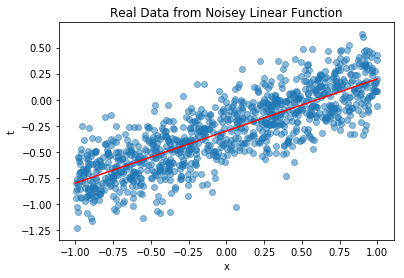

In [19]:
linbayes.make_scatter(x_real, t_real, real_parms = [a_0, a_1]) #our real noisy data

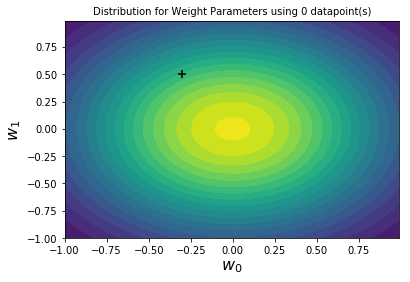

In [20]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=0)

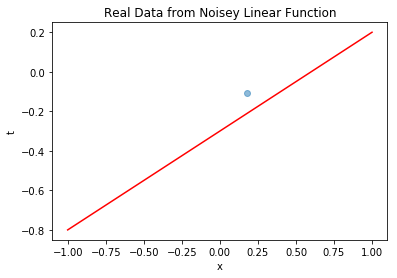

In [21]:
#Let's pull out a single data point from our real data and see how it relates to the true function.
N=1
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

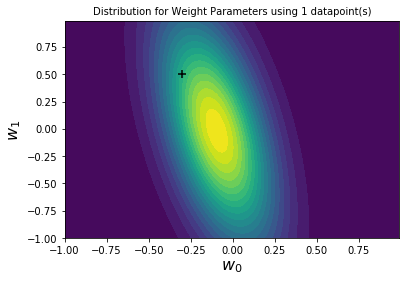

In [22]:
#posterior distribution using above datapoint
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=N)

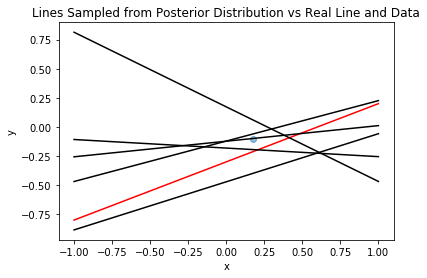

In [58]:
#Let's pull random samples from this distribution to get a collection of w_0, w_1.
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5)

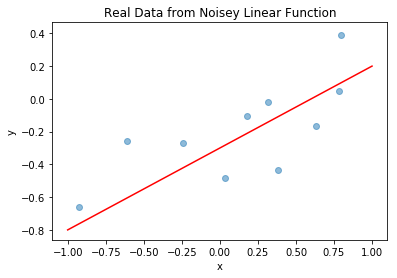

In [62]:
# Now let's use 10 sample points
N=10
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

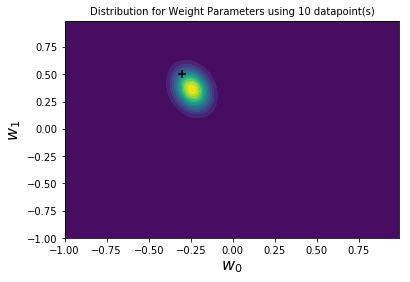

In [63]:
#posterior distribution using 10 data points.
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=N)

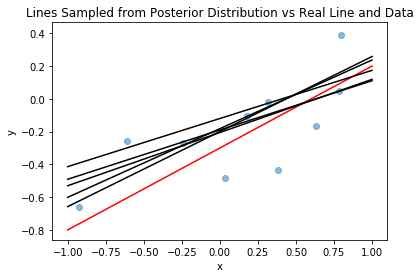

In [66]:
#Let's pull some samples from this distribution to generate example estimates.
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5)